# iMCSpec (iSpec+emcee)

iMCSpec is a tool which combines iSpec(https://www.blancocuaresma.com/s/iSpec) and emcee(https://emcee.readthedocs.io/en/stable/) into a single unit to perform Bayesian analysis of spectroscopic data to estimate stellar parameters. For more details on the individual code please refer to the links above. This code have been tested on Syntehtic dataset as well as GAIA BENCHMARK stars (https://www.blancocuaresma.com/s/benchmarkstars). The example shown here is for the grid genarated MARCS.GES_atom_hfs. If you want to use any other grid, just download it from the https://www.cfa.harvard.edu/~sblancoc/iSpec/grid/ and make the necessary changes in the line_regions.

Let us import all the necessary packages that are required for this analysis. 

In [19]:
import os
import sys
import numpy as np
import pandas as pd
import emcee
from multiprocessing import Pool
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"
os.environ['QT_QPA_PLATFORM']='offscreen'
os.environ["NUMEXPR_MAX_THREADS"] = "8"      #CHECK NUMBER OF CORES ON YOUR MACHINE AND CHOOSE APPROPRIATELY 

ispec_dir = '/home/swastik/iSpec'               #MENTION YOUR DIRECTORY WHERE iSPEC is present     
sys.path.insert(0, os.path.abspath(ispec_dir))

import ispec
#np.seterr(all="ignore")                     #FOR MCMC THE WARNING COMES FOR RED BLUE MOVES WHEN ANY PARTICULAR WALKER VALUE DONOT LIE IN THE PARAMETER SPACE

Let us read the input spectra. Here I have the input spectrum in .txt format for reading the spectra. You can use the .fits format also for reading the spectra using Astropy (https://docs.astropy.org/en/stable/io/fits/). Please note that my input spectra is normalized and radial velocity (RV) corrected. For normalization and RV correction you can used iSpec or iraf. 

In [21]:
df = pd.read_csv('/home/swastik/Downloads/test/HPArcturus.txt', sep ='\s+')   #ENTER YOUR INPUT SPECTRA
df = df[df.flux != 0]                                                   #FOR SOME SPECTROGRAPH PARTS OF SPECTRA ARE MISSING AND THE CORRESPONDING FLUX VALUES ARE LABELLED AS ZEROS. WE WANT TO IGNORE SUCH POINTS

x = df['waveobs'].values
y = df['flux'].values
yerr = df['err'].values
df = np.array(df,dtype=[('waveobs', '<f8'), ('flux', '<f8'), ('err', '<f8')])

You can perform the analysis on the entire spectrum or choose specific regions/segments for which you want to perform the analysis for.

In [22]:
#--- Read lines with atomic data ------------------------------------------------

# line_regions = ispec.read_line_regions(ispec_dir + "/input/regions/47000_GES/grid_synth_good_for_params_all.txt") #CHANGE THIS ACCORDINGLY FOR THE INPUT GRID          
# line_regions = ispec.adjust_linemasks(df, line_regions, max_margin=0.5)
# segments = ispec.create_segments_around_lines(line_regions, margin=0.5)   


#  ### Add also regions from the wings of strong lines:
# ## H beta
# hbeta_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/wings_Hbeta_segments.txt")
# #segments = hbeta_segments
# segments = np.hstack((segments, hbeta_segments))
# ## H ALPHA
# halpha_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/wings_Halpha_segments.txt")
# segments = np.hstack((segments, halpha_segments))
# ## MG TRIPLET
# mgtriplet_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/wings_MgTriplet_segments.txt")
# segments = np.hstack((segments, mgtriplet_segments))
##IRON
# fe_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/fe_lines_segments.txt")
# segments = np.hstack((segments, fe_segments))
##CALCIUM TRIPLET
# catriplet_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/Calcium_Triplet_segments.txt")
# segments = np.hstack((segments, catriplet_segments))
##Na doublet
# NaDoublet_segments = ispec.read_segment_regions(ispec_dir + "/input/regions/Calcium_Triplet_segments.txt")
# segments = np.hstack((segments, NaDoublet_segments_segments))

In [23]:
# for j in range(len(segments)):
#     segments[j][0] = segments[j][0]+0.05
#     segments[j][1] = segments[j][1]-0.05
#YOU CAN CHANGE THE STARTING AND ENDING POINTS OF THE SEGEMENT

I will create a mask all false values with the same dimension as my original spectra in 1D. I will keep only those values of wavelength and flux for which the value falls in the segments (i.e, Mask is True).

In [24]:
# mask =np.zeros(x.shape,dtype =bool)
# for i in range(len(segments)):
#     mask|= (x>segments[i][0])&(x<segments[i][1])

In [15]:
# x = x[mask]                         #SELECTING THOSE VALUES ONLY FOR WHICH MASK VALUE IS TRUE
# y = y[mask]
# #yerr = yerr[mask]
yerr = y*0.0015                     #IF ERROR IS NOT SPECIFIED YOU CAN CHOOSE ACCORDINGLY

Now let us interpolate the spectrum using iSpec. Here for simplicity I have considered only Teff, log g and [M/H] as free parameters. Vmic and Vmac are obtained from emperical relations by Jofre et al.2013 and Maria Bergemann

In [25]:
def synthesize_spectrum(theta):
    teff ,logg ,MH = theta
#    alpha = ispec.determine_abundance_enchancements(MH)
    alpha =0.0
    microturbulence_vel = ispec.estimate_vmic(teff, logg, MH) 
    macroturbulence = ispec.estimate_vmac(teff, logg, MH) 
    limb_darkening_coeff = 0.6
    resolution = 47000
    vsini = 1.6                                                                                                                             #CHANGE HERE
    code = "grid"
    precomputed_grid_dir = ispec_dir + "/input/grid/SPECTRUM_MARCS.GES_GESv6_atom_hfs_iso.480_680nm/"
#    precomputed_grid_dir = ispec_dir + "/input/grid/SPECTRUM_MARCS.GES_GESv6_atom_hfs_iso.480_680nm_light/"
#    The light grid comes bundled with iSpec. It is just for testing purpose. Donot use it for Scientific purpose.
    grid = ispec.load_spectral_grid(precomputed_grid_dir)

    atomic_linelist = None
    isotopes = None
    modeled_layers_pack = None
    solar_abundances = None
    fixed_abundances = None
    abundances = None
    atmosphere_layers = None
    regions = None
        
    if not ispec.valid_interpolated_spectrum_target(grid, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha, 'vmic': microturbulence_vel}):
        msg = "The specified effective temperature, gravity (log g) and metallicity [M/H] \
                fall out of the spectral grid limits."
        print(msg)

    # Interpolation
    synth_spectrum = ispec.create_spectrum_structure(x)
    synth_spectrum['flux'] = ispec.generate_spectrum(synth_spectrum['waveobs'], \
            atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, abundances, \
            fixed_abundances, microturbulence_vel = microturbulence_vel, \
            macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff, \
            R=resolution, regions=regions, verbose=1,
            code=code, grid=grid)
    return synth_spectrum

You can also synthesize the spectrum directly from various atmospheric models. A skeleton of the code taken from iSpec is shown below. For more details check example.py in iSpec.

In [26]:
# def synthesize_spectrum(theta,code="spectrum"):
#     teff ,logg ,MH = theta
#     resolution = 47000
#     alpha = ispec.determine_abundance_enchancements(MH)
#     microturbulence_vel = ispec.estimate_vmic(teff, logg, MH)
#     macroturbulence = ispec.estimate_vmac(teff, logg, MH)

#     limb_darkening_coeff = 0.6
#     regions = None

#     # Selected model amtosphere, linelist and solar abundances
    
#     #model = ispec_dir + "/input/atmospheres/MARCS/"
#     #model = ispec_dir + "/input/atmospheres/MARCS.GES/"
#     #model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
#     #model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
#     model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
#     #model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
#     #model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/" 

#     #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
#     #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
#     atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
#     #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"
    
#     isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"
    

#     atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=wave_base, wave_top=wave_top)
#     atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01]

#     isotopes = ispec.read_isotope_data(isotope_file)

#     if "ATLAS" in model:
#         solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
#     else:
#         # MARCS
#         solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
#     #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
#     #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
#     #solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

#     modeled_layers_pack = ispec.load_modeled_layers_pack(model)
#     solar_abundances = ispec.read_solar_abundances(solar_abundances_file)
    
#     ## Custom fixed abundances
#     #fixed_abundances = ispec.create_free_abundances_structure(["C", "N", "O"], chemical_elements, solar_abundances)
#     #fixed_abundances['Abund'] = [-3.49, -3.71, -3.54] # Abundances in SPECTRUM scale (i.e., x - 12.0 - 0.036) and in the same order ["C", "N", "O"]
#     ## No fixed abundances
#     fixed_abundances = None

#     atmosphere_layers = ispec.interpolate_atmosphere_layers(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}, code=code)
#     synth_spectrum = ispec.create_spectrum_structure(x)
#     synth_spectrum['flux'] = ispec.generate_spectrum(synth_spectrum['waveobs'],
#             atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, solar_abundances,
#             fixed_abundances, microturbulence_vel = microturbulence_vel,
#             macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff,
#             R=resolution, regions=regions, verbose=0,
#             code=code)

#     return synth_spectrum

So far we have discussed about reading the input original spectra and interpolating the synthetic spectra from iSpec. Now the important part that comes into picture is to compare the original spectra and the interpolated spectra. For this we will use Montecarlo Markhov chain method to compare both the spectrums. For this we have used the emcee package by 
Dan Foreman-Mackey.  

In [27]:
walkers = eval(input("Enter Walkers: "))    #WALKER IMPLIES THE INDEPENDENT RANDOMLY SELECTED PARAMETER SETS. NOTE IT SHOULD HAVE ATLEAST TWICE THE VALUE OF AVAILABLE FREE PARAMETERS
Iter = eval(input("Enter Iterations: "))    #ITERATION IMPLIES NUMBER OF RUNS THE PARAMETERS WILL BE CHECKED FOR CONVERGENCE. FOR MOST CASES 250-300 SHOULD DO.


Enter Walkers: 8
Enter Iterations: 120


We will be creating four functions for this MCMC run. The first is straightforward, and is known as the model. The model function should take as an argument a list representing our θ vector, and return the model evaluated at that θ. For completion, your model function should also have your parameter array as an input. The form of this function comes from the Gaussian probability distribution P(x)dx.

In [28]:
def log_likelihood(theta):
    model = synthesize_spectrum(theta)    #GENARATING THE SPECTRUM FOR A GIVEN VALUE OF THETA
    sigma2 = yerr ** 2                    # FINDING THE Variance
    return -0.5 * np.sum((y - (model['flux'])) ** 2/ sigma2)     # returns the -chi^2/2 value 

There is no unique way to set up your prior function. For the simplistic case we have choosen the log prior function returns zero if the input values genarated randomly lies wittin the specified ranges and -infinity if it doesnt(atleast one vale should satisty this criterion). You can choose your own prior function as well.

In [34]:
def log_prior(theta):
    teff, logg, MH = theta
    if 3200 < teff < 6900 and 1.1 < logg < 4.8 and -2.49 < MH <= 0.49 :                                                       #CHANGE HERE
        return 0.0
    return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it’s the lnprior output + lnlike output, since lnprior’s output should be zero if the priors are good). lnprob needs to take as arguments theta,x,y,and yerr, since these get passed through to lnlike.

In [35]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

Select input guess values and create intial set of stellar parameters RANDOMLY

In [36]:
initial = np.array([4650,1.8,-0.7])         #INPUT GUESS VALUES                                                         
pos = initial + np.array([100,0.1,0.1])*np.random.randn(walkers, 3)      # YOU CAN CHOOSE UNIFORM RANDOM FUNCTION OR GAUSSIAUN RANDOM NUMBER GENARATOR
nwalkers, ndim = pos.shape

Now we will run the EMCEE sampler to run the code. This will take some time depending on the your system. But don't worry :)

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos,Iter, progress=True)

100%|██████████| 120/120 [2:10:57<00:00, 65.48s/it] 


State([[ 4.32736776e+03  1.58554183e+00 -4.36054183e-01]
 [ 4.32993628e+03  1.57779182e+00 -4.34564501e-01]
 [ 4.32588761e+03  1.58896911e+00 -4.37900305e-01]
 [ 4.21609605e+03  1.33028649e+00 -6.11764183e-01]
 [ 4.31102634e+03  1.53459353e+00 -4.62972002e-01]
 [ 4.32682284e+03  1.58575530e+00 -4.35708566e-01]
 [ 4.32671310e+03  1.57992175e+00 -4.38617944e-01]
 [ 4.32875873e+03  1.57985484e+00 -4.37055116e-01]], log_prob=[-1.74668559e+08 -1.74680058e+08 -1.74670752e+08 -1.74965215e+08
 -1.74819554e+08 -1.74676972e+08 -1.74691959e+08 -1.74676596e+08], blobs=None, random_state=('MT19937', array([ 352203286, 4047333849, 3903382424, 2442437959, 4089492394,
       2740829932, 3613163978, 1560291436,  320658228, 1121440048,
       3634222839,  728477864,  566862146, 2118643008,   70409224,
        650238969,  585933837,  633224605, 2888018859, 3280086169,
       4228036133, 1612281127, 1775884190, 2341688769, 4122198348,
       3540031050, 2646426272, 4264868081, 3864700085, 2531435222,
    

Let us plot the Walkers and Iterations. Check out for convergence in this plot. If you see the convergence you are good to go. 

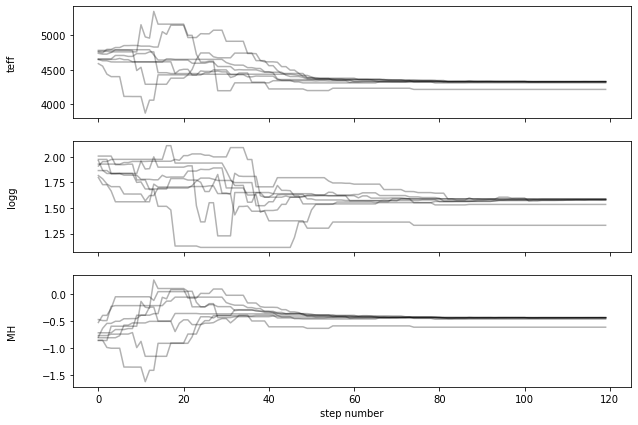

In [41]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
accepted = sampler.backend.accepted.astype(bool)   #Here accepted indicated that the lines for each parameter below have converged/moved at least one time.

labels = ["teff","logg","MH"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

Let us check how good is the fitting.....

('Theta max: ', array([ 4.32736776e+03,  1.58554183e+00, -4.36054183e-01]))


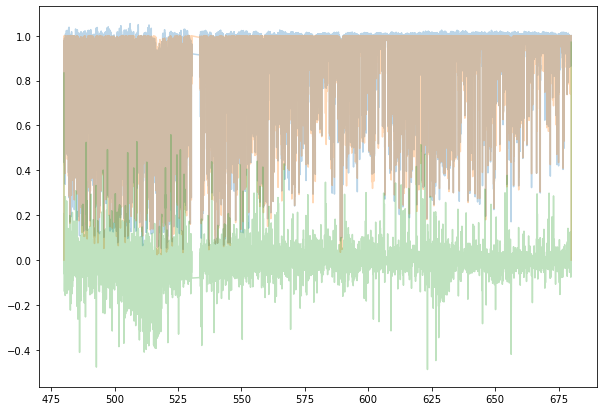

In [42]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = synthesize_spectrum(theta_max)
ax.plot(x,y,alpha=0.3)
ax.plot(x,best_fit_model['flux'],alpha =0.3)
ax.plot(x,y-best_fit_model['flux'],alpha =0.3)
plt.savefig('t2.pdf')                                                                                                #CHANGE HERE
print(('Theta max: ',theta_max))             # Genarating the spectrum for the Maximum likelyhood function.
#NOTE THE SPIKES IN THE PLOT BELOW. THESE ARE DUE TO THE FACT THAT END POINTS OF THE SPECTRUMS ARE EXTRAPOLATED

Since the first few runs the walkers are exploring the parameter space and convergence have not yet been achived. We will ignore such runs. This is also known as "BURN-IN".

In [18]:
new_samples = sampler.get_chain(discard=100, thin=1, flat=False)        
new_samples = new_samples[:,accepted,:]                       # WE ARE ONLY CHOOSING THE VALUES FOR WHICH THE WALKER HAVE MOVED ATLEAST ONCE DURING THE ENTIRE ITERATION. Stagnent walkers indicates that the prior function might have returned -inf. 

Checking the Convergence after the BURN-IN... If it seems to be converged then it is DONE.

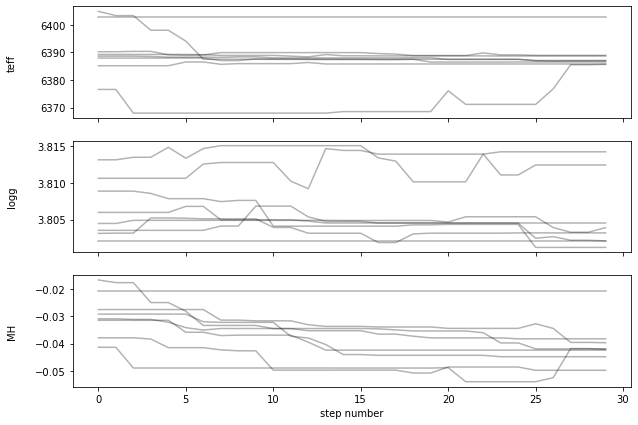

In [19]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(new_samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.savefig('t3.pdf')                                                                                                  #CHANGE HERE
flat_samples = new_samples.reshape(-1,new_samples.shape[2])
np.savetxt("RNtesto.txt",flat_samples,delimiter='\t')                                                                                   #CHANGE HERE


# DATA VISUALIZATION

Now after the final list of stellar parameters it is important to visualise the stellar parameter distribution. Also it is important to check for any correlation among the stellar parameters. Here I have shown two medhods by which you can do this. Note: I have taken very few points for analysis and for a proper plot you actually need a much larger dataset (40x300:150 Burns at minimum)

In [23]:
import corner
from pandas.plotting import scatter_matrix 

array([[<AxesSubplot:title={'center':'$T_{eff}$'}>,
        <AxesSubplot:title={'center':'logg'}>],
       [<AxesSubplot:title={'center':'[M/H]'}>, <AxesSubplot:>]],
      dtype=object)

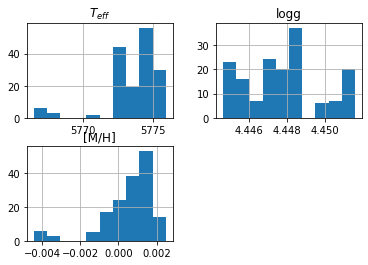

In [43]:
df  = pd.read_csv('/home/swastik/RNtesto.txt',delimiter='\t',header = None)   
df.columns = ["$T_{eff}$", "logg", "[M/H]"]
df.hist() #Plotting Histogram for each individual stellar parameters. THIS NEED NOT BE A GAUSSIAN ONE

In [44]:
#df = df[df.logg < 4.451 ] #REMOVE ANY OUTLIER DISTRIBUTION

array([[<AxesSubplot:xlabel='$T_{eff}$', ylabel='$T_{eff}$'>,
        <AxesSubplot:xlabel='logg', ylabel='$T_{eff}$'>,
        <AxesSubplot:xlabel='[M/H]', ylabel='$T_{eff}$'>],
       [<AxesSubplot:xlabel='$T_{eff}$', ylabel='logg'>,
        <AxesSubplot:xlabel='logg', ylabel='logg'>,
        <AxesSubplot:xlabel='[M/H]', ylabel='logg'>],
       [<AxesSubplot:xlabel='$T_{eff}$', ylabel='[M/H]'>,
        <AxesSubplot:xlabel='logg', ylabel='[M/H]'>,
        <AxesSubplot:xlabel='[M/H]', ylabel='[M/H]'>]], dtype=object)

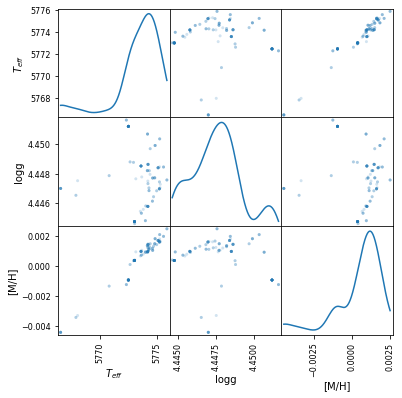

In [45]:
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde') #PLOTTING THE SCATTER MATRIX. I HAVE USED A VERY LIGHT DATASET FOR TEST PURPOSE> YOU CAN USE A MORE WALKER X ITERATION FOR A BETTER RESULT

In [46]:
samples = np.vstack([df]) #IT IS NECESSARY TO STACK THE DATA VERTICALLY TO OBTAIN THE DISTRIBUTION FROM THE DATA FRAME

In [39]:
value2 = np.mean(samples, axis=0) 
plt.rcParams["font.size"] = "10"     #THIS CHANGES THE FONT SIZE OF THE LABELS(NOT LEGEND)

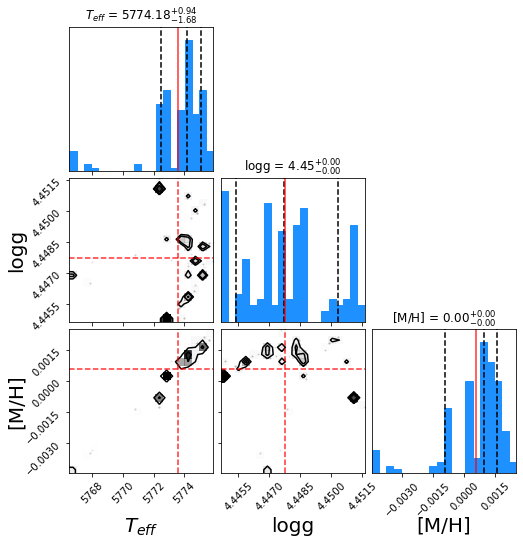

In [47]:
#FINALLY... MAKING THE CORNER PLOT>>>>


#fig = corner.corner(df,show_titles=True,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],color ='black',levels=(1-np.exp(-0.5),),label_kwargs=dict(fontsize=20,color = 'black'),hist_kwargs=dict(fill = True,color = 'dodgerblue'),alpha =0.2)
fig = corner.corner(df,show_titles=True,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],color ='black',label_kwargs=dict(fontsize=20,color = 'black'),hist_kwargs=dict(fill = True,color = 'dodgerblue'),alpha =0.2)
axes = np.array(fig.axes).reshape((3, 3))
for i in range(3):
    ax = axes[i, i]
    ax.axvline(value2[i], color="r",alpha =0.8)
for yi in range(3):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="r",alpha =0.8,linestyle = 'dashed')
        ax.axhline(value2[yi], color="r",alpha =0.8,linestyle = 'dashed')
        ax.plot(value2[xi], value2[yi], "r")
#         plt.tight_layout()
#THE CORNER PLOT DONOT LOOK GREAT>> THE REASON IS FEW NUMBER OF DATA POINTS AND SHARP CONVERGENCE

I would like to thank Sergi blanco-cuaresma for the valuable suggestions and feedbacks regarding the iSpec code and its intregation with emcee. I would also thank 
Dan Foreman-Mackey for his insightful comments on using emcee. I would also like to thank Aritra Chakraborty and Dr.Ravinder Banyal for their comments and suggestion on improving the code which might have not been possible without their help.